In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %pip install dlib timm scikit-learn matplotlib seaborn tqdm

import os
import cv2
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, confusion_matrix,
    roc_curve, auc, precision_score, recall_score
)

import seaborn as sns

import dlib

ROOT_PATH = '/content/drive/MyDrive/ff_c23_data'

X_train = torch.load(os.path.join(ROOT_PATH, 'X_train.pt'), weights_only=False)
y_train = torch.load(os.path.join(ROOT_PATH, 'y_train.pt'), weights_only=False)
X_val = torch.load(os.path.join(ROOT_PATH, 'X_val.pt'), weights_only=False)
y_val = torch.load(os.path.join(ROOT_PATH, 'y_val.pt'), weights_only=False)
X_test = torch.load(os.path.join(ROOT_PATH, 'X_test.pt'), weights_only=False)
y_test = torch.load(os.path.join(ROOT_PATH, 'y_test.pt'), weights_only=False)

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)
OUTPUT_FRAME_SIZE = (224, 224)
FRAME_COUNT = 15
MAX_VIDEOS = 200

BATCH_SIZE = 8
NUM_WORKERS = 2  # set 0 on Windows / if dataloader issues
SEED = 42

# Training
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 60
LR_PHASE1 = 1e-4
LR_PHASE2 = 1e-6

PADDING_FACTOR = 1.3
EARLY_STOP_PATIENCE = 10

# Model options
BACKBONE_NAME = "xception"   # from timm
HIDDEN_SIZE = 128
DROPOUT = 0.4
USE_SPATIAL_FLATTEN = False  # True = match original (huge vector), False = GAP (recommended)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)



Train/Val/Test: (279, 15, 224, 224, 3) (60, 15, 224, 224, 3) (60, 15, 224, 224, 3)
device: cuda


In [3]:
# --------------------
# PyTorch Dataset / DataLoader
# --------------------
from torchvision import transforms

# ImageNet normalization (timm's xception expects this style)
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

train_frame_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # uint8 -> float in [0,1]
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_frame_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

class VideoNumpyDataset(Dataset):
    def __init__(self, X, y, frame_transform):
        self.X = X
        self.y = y
        self.frame_transform = frame_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # (T,H,W,C) uint8
        label = int(self.y[idx])

        frames = []
        for t in range(video.shape[0]):
            frame = video[t]  # (H,W,C) BGR from cv2
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(self.frame_transform(frame))  # (C,H,W)

        video_tensor = torch.stack(frames, dim=0)  # (T,C,H,W)
        return video_tensor, torch.tensor(label, dtype=torch.long)

train_ds = VideoNumpyDataset(X_train, y_train, train_frame_tfms)
val_ds   = VideoNumpyDataset(X_val,   y_val,   val_frame_tfms)
test_ds  = VideoNumpyDataset(X_test,  y_test,  val_frame_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

# Class weights (for imbalance)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("class_weights:", class_weights)

class_weights: [1.00359712 0.99642857]


In [4]:
CFG = dict(
    # --- experiment ---
    exp_name="deepfake_run1",
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",

    # --- model ---
    model_type="lstm",                 # "voter" or "lstm"
    backbone="vit_base",                # efficientnet_b0, xception, vit_base/small, ...
    pretrained=True,
    img_size=224,
    in_chans=3,

    finetune_backbone=True,            # True finetunes backbone, False freezes backbone
    backbone_last_n_unfreeze=3,

    num_classes=2,

    # voter settings
    aggregation="soft_vote",            # mean | median | max | soft_vote | hard_vote
    temperature=1.0,

    # lstm settings
    lstm_hidden=256,
    lstm_layers=1,
    bidirectional=True,
    temporal_pool="last",               # last | mean | max | attn
    attn_dim=128,

    # --- optimization ---
    epochs=10,
    lr=3e-4,
    weight_decay=1e-4,
    optimizer="adamw",                  # adamw | adam
    scheduler=None,                     # None | "cosine" | "step"
    step_size=3,
    gamma=0.5,

    # two-phase optional (mimics "freeze then finetune" workflow if you want)
    two_phase=True,                    # if True: warmup (frozen) then unfreeze for finetune
    warmup_epochs=3,
    lr_finetune=1e-5,

    # --- training ---
    amp=True,                           # mixed precision
    grad_clip=1.0,
    threshold=0.5,                      # threshold for FAKE (class 1)
    save_dir="/content/checkpoints",
    monitor="val_auc",                  # val_auc | val_accuracy | val_loss
    minimize_monitor=False,             # False for auc/acc, True for loss
)

os.makedirs(CFG["save_dir"], exist_ok=True)


In [5]:
_BACKBONE_PRESETS = {
    "efficientnet": "efficientnet_b0",
    "efficientnet_b0": "efficientnet_b0",
    "efficientnet_b2": "efficientnet_b2",
    "mobilenetv3": "mobilenetv3_large_100",
    "mobilenetv3_large": "mobilenetv3_large_100",
    "mobilenetv3_small": "mobilenetv3_small_100",
    "xception": "xception",
    "vit": "vit_base_patch16_224",
    "vit_base": "vit_base_patch16_224",
    "vit_small": "vit_small_patch16_224",
    "tinyvit": "tinyvit_21m_224",
    "tinyvit_11m": "tinyvit_11m_224",
    "tinyvit_21m": "tinyvit_21m_224",
}

def freeze_all(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

def unfreeze_all(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def set_backbone_trainable_last_layers(
    backbone: nn.Module,
    last_n: int = -1,
    *,
    always_train_head: bool = True,
    always_train_norms: bool = True,
):
    """
    last_n:
      - -1 => unfreeze ALL backbone params (full finetune)
      -  0 => freeze ALL backbone params
      - >0 => unfreeze only the last N layers/blocks (heuristic)

    Notes:
      - For ViT/TinyViT: unfreezes last N transformer blocks if available.
      - For CNNs or unknown arch: unfreezes last fraction by parameter order.
    """
    # Default: freeze everything
    freeze_all(backbone)

    # Degenerate cases
    if last_n is None:
        return
    if last_n < 0:
        unfreeze_all(backbone)
        return
    if last_n == 0:
        # keep frozen
        return

    # 1) Transformer-style: timm ViT has `blocks` (ModuleList)
    if hasattr(backbone, "blocks") and isinstance(backbone.blocks, nn.ModuleList):
        n_blocks = len(backbone.blocks)
        start = max(0, n_blocks - last_n)
        for i in range(start, n_blocks):
            for p in backbone.blocks[i].parameters():
                p.requires_grad = True

        # Also unfreeze final norms if present
        if always_train_norms:
            for attr in ["norm", "fc_norm"]:
                if hasattr(backbone, attr):
                    for p in getattr(backbone, attr).parameters():
                        p.requires_grad = True

        # Some timm transformers have `patch_embed` and `pos_embed`; keep frozen by default
        # unless last_n is very large; you can customize if you want.
        return

    # 2) Some convnets have `stages` or `blocks` but not transformer blocks
    if hasattr(backbone, "stages") and isinstance(backbone.stages, nn.ModuleList):
        n_stages = len(backbone.stages)
        start = max(0, n_stages - last_n)
        for i in range(start, n_stages):
            for p in backbone.stages[i].parameters():
                p.requires_grad = True
        if always_train_norms:
            for m in backbone.modules():
                if isinstance(m, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)):
                    for p in m.parameters():
                        p.requires_grad = True
        return

    # 3) Fallback heuristic: unfreeze last X% by parameter order
    params = list(backbone.parameters())
    n_params = len(params)
    if n_params == 0:
        return

    # Interpret last_n as "chunks" (layers) in param order.
    # We split parameters into 10 chunks; last_n selects how many chunks to unfreeze.
    # If last_n > 10, we just unfreeze everything.
    chunks = 10
    if last_n >= chunks:
        unfreeze_all(backbone)
    else:
        cut = int(math.floor((chunks - last_n) / chunks * n_params))
        for p in params[cut:]:
            p.requires_grad = True

    # Optionally unfreeze norms (helps finetuning stability)
    if always_train_norms:
        for m in backbone.modules():
            if isinstance(m, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)):
                for p in m.parameters():
                    p.requires_grad = True

def create_timm_backbone(backbone, pretrained=True, img_size=224, in_chans=3, finetune_backbone=True):
    name = _BACKBONE_PRESETS.get(str(backbone).lower(), backbone)

    # Try the most informative set of kwargs first, then fall back by removing unsupported ones.
    kwargs = dict(
        pretrained=pretrained,
        num_classes=0,       # remove classifier head in timm
        global_pool="avg",   # return (B, feat_dim)
        in_chans=in_chans,
        img_size=img_size,   # some models (ViT/TinyViT) accept this; many CNNs don't
    )

    def _try_create(kws):
        return timm.create_model(name, **kws)

    try:
        m = _try_create(kwargs)
    except TypeError as e:
        msg = str(e)

        # Common: CNNs don't take img_size
        if "img_size" in msg and "unexpected keyword argument" in msg:
            kwargs.pop("img_size", None)

        # Some models may also not accept global_pool at ctor time
        if "global_pool" in msg and "unexpected keyword argument" in msg:
            kwargs.pop("global_pool", None)

        # Retry after dropping unsupported kwargs
        m = _try_create(kwargs)

    # Feature dim
    feat_dim = getattr(m, "num_features", None)
    if feat_dim is None:
        # fallback: infer via a dry-run using model's preferred input size if available
        with torch.no_grad():
            if hasattr(m, "default_cfg") and "input_size" in m.default_cfg:
                _, c, h, w = m.default_cfg["input_size"]
            else:
                c, h, w = in_chans, img_size, img_size
            dummy = torch.zeros(1, c, h, w)
            out = m(dummy)
        feat_dim = out.shape[-1]

    return m, int(feat_dim)

def aggregate_frame_logits(frame_logits, mode="soft_vote", temperature=1.0):
    # frame_logits: (B,T,2)
    if mode == "mean":
        return frame_logits.mean(dim=1)
    if mode == "median":
        return frame_logits.median(dim=1).values
    if mode == "max":
        return frame_logits.max(dim=1).values
    if mode == "soft_vote":
        probs = F.softmax(frame_logits / max(temperature, 1e-6), dim=-1)   # (B,T,2)
        p = probs.mean(dim=1).clamp(1e-6, 1 - 1e-6)                        # (B,2)
        return torch.log(p)                                                # logits up to constant
    if mode == "hard_vote":
        preds = frame_logits.argmax(dim=-1)                                # (B,T)
        votes = (preds == 1).sum(dim=1)
        T = preds.size(1)
        majority = (votes >= (T / 2)).long()
        out = torch.zeros(frame_logits.size(0), 2, device=frame_logits.device)
        out[:, 0] = torch.where(majority == 0, torch.tensor(10.0, device=out.device), torch.tensor(-10.0, device=out.device))
        out[:, 1] = -out[:, 0]
        return out
    raise ValueError(f"Unknown aggregation mode: {mode}")

class VisionFrameVoter(nn.Module):
    def __init__(self, backbone="xception", pretrained=True, img_size=224, in_chans=3,
                 finetune_backbone=True, aggregation="soft_vote", temperature=1.0,
                 dropout=0.2, num_classes=2):
        super().__init__()
        self.backbone, feat_dim = create_timm_backbone(
            backbone, pretrained=pretrained, img_size=img_size, in_chans=in_chans,
            finetune_backbone=finetune_backbone
        )
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(feat_dim, num_classes))
        self.aggregation = aggregation
        self.temperature = temperature

    def forward(self, frames):
        # frames: (B,T,C,H,W)
        B, T, C, H, W = frames.shape
        x = frames.view(B*T, C, H, W)
        feats = self.backbone(x)
        logits = self.head(feats).view(B, T, -1)   # (B,T,2)
        video_logits = aggregate_frame_logits(logits, mode=self.aggregation, temperature=self.temperature)
        return video_logits

class VisionLSTM(nn.Module):
    def __init__(self, backbone="xception", pretrained=True, img_size=224, in_chans=3,
                 finetune_backbone=True, lstm_hidden=256, lstm_layers=1, bidirectional=False,
                 temporal_pool="last", attn_dim=128, dropout=0.2, num_classes=2):
        super().__init__()
        self.backbone, feat_dim = create_timm_backbone(
            backbone, pretrained=pretrained, img_size=img_size, in_chans=in_chans,
            finetune_backbone=finetune_backbone
        )

        self.temporal_pool = temporal_pool
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )

        out_dim = lstm_hidden * (2 if bidirectional else 1)

        if temporal_pool == "attn":
            self.attn = nn.Sequential(
                nn.Linear(out_dim, attn_dim),
                nn.Tanh(),
                nn.Linear(attn_dim, 1),
            )
        else:
            self.attn = None

        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(out_dim, num_classes))

    def forward(self, frames):
        B, T, C, H, W = frames.shape
        x = frames.view(B*T, C, H, W)
        feats = self.backbone(x).view(B, T, -1)     # (B,T,F)
        seq, _ = self.lstm(feats)                   # (B,T,H)

        if self.temporal_pool == "last":
            pooled = seq[:, -1]
        elif self.temporal_pool == "mean":
            pooled = seq.mean(dim=1)
        elif self.temporal_pool == "max":
            pooled = seq.max(dim=1).values
        elif self.temporal_pool == "attn":
            scores = self.attn(seq).squeeze(-1)                 # (B,T)
            w = torch.softmax(scores, dim=1).unsqueeze(-1)      # (B,T,1)
            pooled = (seq * w).sum(dim=1)
        else:
            raise ValueError(f"Unknown temporal_pool: {self.temporal_pool}")

        return self.head(pooled)

def build_model(cfg):
    if cfg["model_type"].lower() == "voter":
        return VisionFrameVoter(
            backbone=cfg["backbone"], pretrained=cfg["pretrained"],
            img_size=cfg["img_size"], in_chans=cfg["in_chans"],
            finetune_backbone=cfg["finetune_backbone"],
            aggregation=cfg["aggregation"], temperature=cfg["temperature"],
            num_classes=cfg["num_classes"]
        )
    elif cfg["model_type"].lower() == "lstm":
        return VisionLSTM(
            backbone=cfg["backbone"], pretrained=cfg["pretrained"],
            img_size=cfg["img_size"], in_chans=cfg["in_chans"],
            finetune_backbone=cfg["finetune_backbone"],
            lstm_hidden=cfg["lstm_hidden"], lstm_layers=cfg["lstm_layers"],
            bidirectional=cfg["bidirectional"],
            temporal_pool=cfg["temporal_pool"], attn_dim=cfg["attn_dim"],
            num_classes=cfg["num_classes"]
        )
    else:
        raise ValueError("CFG['model_type'] must be 'voter' or 'lstm'")

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def labels_to_int(y):
    # supports int labels or one-hot
    if isinstance(y, torch.Tensor):
        if y.dim() > 1 and y.size(-1) > 1:
            return y.argmax(dim=-1).long()
        return y.long()
    y = torch.as_tensor(y)
    if y.dim() > 1 and y.size(-1) > 1:
        return y.argmax(dim=-1).long()
    return y.long()

def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    return 0.0 if (TN + FP) == 0 else (TN / (TN + FP))

def compute_metrics_from_logits(logits, y_true, threshold=0.5):
    """
    Returns metrics aligned with your first file:
      Accuracy, Precision(pos=1), Recall(pos=1), Specificity(pos=0), AUC
    """
    y_true = np.asarray(y_true).astype(int)
    probs = torch.softmax(torch.as_tensor(logits), dim=-1).cpu().numpy()
    p_fake = probs[:, 1]
    y_pred = (p_fake > threshold).astype(int)

    acc = accuracy_score(y_true, y_pred) * 100.0
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0) * 100.0
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0) * 100.0
    spec = recall_score(y_true, y_pred, pos_label=0, zero_division=0) * 100.0  # matches your baselines cell
    # AUC can fail if only 1 class present in y_true
    try:
        auc_score = roc_auc_score(y_true, p_fake) * 100.0
    except Exception:
        auc_score = float("nan")

    return dict(
        Accuracy=acc,
        Precision=prec,
        Recall=rec,
        Specificity=spec,
        AUC=auc_score,
        y_pred=y_pred,
        p_fake=p_fake,
    )

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Real", "Fake"]
    plt.figure(figsize=(6.5, 5.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def plot_roc_curve(y_true, p_fake):
    fpr, tpr, _ = roc_curve(y_true, p_fake)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6.5, 5.5))
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR) / Recall")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

def plot_training_history(history):
    # history keys: loss, val_loss, accuracy, val_accuracy (and optionally auc)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy over Epochs")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Model Loss over Epochs")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

def make_optimizer(cfg, model):
    params = [p for p in model.parameters() if p.requires_grad]
    if cfg["optimizer"].lower() == "adam":
        return torch.optim.Adam(params, lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    return torch.optim.AdamW(params, lr=cfg["lr"], weight_decay=cfg["weight_decay"])

def make_scheduler(cfg, optimizer):
    if cfg["scheduler"] is None:
        return None
    if cfg["scheduler"] == "cosine":
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epochs"])
    if cfg["scheduler"] == "step":
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg["step_size"], gamma=cfg["gamma"])
    raise ValueError("CFG['scheduler'] must be None, 'cosine', or 'step'")

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5, desc="Eval"):
    model.eval()
    all_logits, all_y = [], []
    total_loss, n = 0.0, 0
    ce = nn.CrossEntropyLoss()

    for batch in tqdm(loader, desc=desc, leave=False):
        frames, y = batch
        frames = frames.to(device, non_blocking=True)
        y = labels_to_int(y).to(device, non_blocking=True)

        logits = model(frames)
        loss = ce(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        n += bs

        all_logits.append(logits.detach().cpu())
        all_y.append(y.detach().cpu())

    logits = torch.cat(all_logits, dim=0)
    y_true = torch.cat(all_y, dim=0).numpy().astype(int)

    metrics = compute_metrics_from_logits(logits, y_true, threshold=threshold)
    metrics["loss"] = total_loss / max(n, 1)
    metrics["y_true"] = y_true
    metrics["logits"] = logits.numpy()
    return metrics

def train_one_epoch(model, loader, optimizer, scaler, device, amp=True, grad_clip=1.0, desc="Train"):
    model.train()
    ce = nn.CrossEntropyLoss()

    total_loss, n = 0.0, 0
    all_logits, all_y = [], []

    for batch in tqdm(loader, desc=desc, leave=False):
        frames, y = batch
        frames = frames.to(device, non_blocking=True)
        y = labels_to_int(y).to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=amp):
            logits = model(frames)
            loss = ce(logits, y)

        if amp:
            scaler.scale(loss).backward()
            if grad_clip is not None and grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip is not None and grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        n += bs

        all_logits.append(logits.detach().cpu())
        all_y.append(y.detach().cpu())

    logits = torch.cat(all_logits, dim=0)
    y_true = torch.cat(all_y, dim=0).numpy().astype(int)
    return (total_loss / max(n, 1)), logits, y_true

def pick_monitor_value(metrics, monitor_key):
    if monitor_key == "val_loss":
        return metrics["loss"]
    if monitor_key == "val_accuracy":
        return metrics["Accuracy"]
    if monitor_key == "val_auc":
        return metrics["AUC"]
    raise ValueError("monitor must be one of: val_loss, val_accuracy, val_auc")

def save_checkpoint(path, model, cfg, epoch, best_score, history):
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "cfg": cfg,
            "epoch": epoch,
            "best_score": best_score,
            "history": history,
        },
        path,
    )

def load_checkpoint(path, model, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location, weights_only=False)
    model.load_state_dict(ckpt["model_state_dict"])
    return ckpt

def run_training(cfg, train_loader, val_loader, test_loader=None):
    seed_everything(cfg["seed"])
    device = cfg["device"]

    model = build_model(cfg).to(device)

    last_n = cfg.get("backbone_last_n_unfreeze", -1 if cfg["finetune_backbone"] else 0)

    set_backbone_trainable_last_layers(model.backbone, last_n=last_n)

    optimizer = make_optimizer(cfg, model)
    scheduler = make_scheduler(cfg, optimizer)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg["amp"])

    history = {
        "loss": [], "val_loss": [],
        "accuracy": [], "val_accuracy": [],
        "auc": [], "val_auc": [],
        "precision": [], "val_precision": [],
        "recall": [], "val_recall": [],
        "specificity": [], "val_specificity": [],
        "lr": [],
    }

    best_score = math.inf if cfg["minimize_monitor"] else -math.inf
    best_path = os.path.join(cfg["save_dir"], f"{cfg['exp_name']}_best.pt")

    def is_better(x, best):
        if cfg["minimize_monitor"]:
            return x < best
        return x > best

    # Optional 2-phase: warmup with frozen backbone then unfreeze and finetune
    did_unfreeze = False
    total_epochs = cfg["epochs"]

    for epoch in range(1, total_epochs + 1):
        # two-phase switch
        if cfg["two_phase"] and (epoch == cfg["warmup_epochs"] + 1) and not did_unfreeze:
            # unfreeze backbone
            for p in model.backbone.parameters():
                p.requires_grad = True
            # new optimizer with finetune lr
            cfg = dict(cfg)  # local copy
            cfg["lr"] = cfg["lr_finetune"]
            optimizer = make_optimizer(cfg, model)
            scheduler = make_scheduler(cfg, optimizer)
            scaler = torch.cuda.amp.GradScaler(enabled=cfg["amp"])
            did_unfreeze = True
            print(f"\n[Two-phase] Unfroze backbone at epoch {epoch}. New LR = {cfg['lr']}\n")

        lr_now = optimizer.param_groups[0]["lr"]
        history["lr"].append(lr_now)

        # ---- train
        train_loss, train_logits, train_y = train_one_epoch(
            model, train_loader, optimizer, scaler, device,
            amp=cfg["amp"], grad_clip=cfg["grad_clip"],
            desc=f"Epoch {epoch}/{total_epochs} - Train"
        )
        train_m = compute_metrics_from_logits(train_logits, train_y, threshold=cfg["threshold"])
        train_m["loss"] = train_loss

        # ---- val
        val_m = evaluate(model, val_loader, device, threshold=cfg["threshold"], desc=f"Epoch {epoch}/{total_epochs} - Val")

        # ---- log
        history["loss"].append(train_m["loss"])
        history["val_loss"].append(val_m["loss"])

        history["accuracy"].append(train_m["Accuracy"])
        history["val_accuracy"].append(val_m["Accuracy"])

        history["auc"].append(train_m["AUC"])
        history["val_auc"].append(val_m["AUC"])

        history["precision"].append(train_m["Precision"])
        history["val_precision"].append(val_m["Precision"])

        history["recall"].append(train_m["Recall"])
        history["val_recall"].append(val_m["Recall"])

        history["specificity"].append(train_m["Specificity"])
        history["val_specificity"].append(val_m["Specificity"])

        # ---- monitor + checkpoint
        monitor_key = cfg["monitor"]  # val_auc / val_accuracy / val_loss
        monitor_value = pick_monitor_value(val_m, monitor_key)

        if is_better(monitor_value, best_score):
            best_score = monitor_value
            save_checkpoint(best_path, model, cfg, epoch, best_score, history)

        if scheduler is not None:
            scheduler.step()

        print(
            f"Epoch {epoch:02d} | "
            f"lr={lr_now:.2e} | "
            f"train_loss={train_m['loss']:.4f} val_loss={val_m['loss']:.4f} | "
            f"train_acc={train_m['Accuracy']:.2f}% val_acc={val_m['Accuracy']:.2f}% | "
            f"val_auc={val_m['AUC']:.2f}% | val_rec={val_m['Recall']:.2f}% | val_spec={val_m['Specificity']:.2f}% | "
            f"best({monitor_key})={best_score:.4f}"
        )

    # ---- load best & evaluate
    print(f"\nLoading best checkpoint: {best_path}")
    ckpt = load_checkpoint(best_path, model, map_location=device)

    print("\n--- Training History ---")
    plot_training_history(history)

    print("\n--- Final Validation Metrics (best ckpt) ---")
    val_m = evaluate(model, val_loader, device, threshold=cfg["threshold"], desc="Val (Best)")
    print({k: val_m[k] for k in ["loss","Accuracy","Precision","Recall","Specificity","AUC"]})

    print("\n--- Confusion Matrix (Val) ---")
    plot_confusion_matrix(val_m["y_true"], val_m["y_pred"])

    print("\n--- ROC Curve & AUC Score (Val) ---")
    plot_roc_curve(val_m["y_true"], val_m["p_fake"])

    print("\nClassification Report (Val):")
    print(classification_report(val_m["y_true"], val_m["y_pred"], target_names=["REAL", "FAKE"]))

    test_m = None
    if test_loader is not None:
        print("\n--- Final Test Metrics (best ckpt) ---")
        test_m = evaluate(model, test_loader, device, threshold=cfg["threshold"], desc="Test (Best)")
        print({k: test_m[k] for k in ["loss","Accuracy","Precision","Recall","Specificity","AUC"]})

        print("\n--- Confusion Matrix (Test) ---")
        plot_confusion_matrix(test_m["y_true"], test_m["y_pred"])

        print("\n--- ROC Curve & AUC Score (Test) ---")
        plot_roc_curve(test_m["y_true"], test_m["p_fake"])

        print("\nClassification Report (Test):")
        print(classification_report(test_m["y_true"], test_m["y_pred"], target_names=["REAL", "FAKE"]))

    return model, history, val_m, test_m, best_path


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipython-input-3170804962.py:225: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg["amp"])
Epoch 1/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 01 | lr=3.00e-04 | train_loss=0.6969 val_loss=0.6150 | train_acc=56.27% val_acc=70.00% | val_auc=74.78% | val_rec=83.33% | val_spec=56.67% | best(val_auc)=74.7778


Epoch 2/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 02 | lr=3.00e-04 | train_loss=0.6563 val_loss=0.4518 | train_acc=68.10% val_acc=80.00% | val_auc=88.11% | val_rec=76.67% | val_spec=83.33% | best(val_auc)=88.1111


Epoch 3/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/tmp/ipython-input-3170804962.py:260: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg["amp"])


Epoch 03 | lr=3.00e-04 | train_loss=0.5199 val_loss=0.4836 | train_acc=78.85% val_acc=80.00% | val_auc=89.11% | val_rec=93.33% | val_spec=66.67% | best(val_auc)=89.1111

[Two-phase] Unfroze backbone at epoch 4. New LR = 1e-05



Epoch 4/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 04 | lr=1.00e-05 | train_loss=0.4252 val_loss=0.5779 | train_acc=82.08% val_acc=80.00% | val_auc=92.78% | val_rec=63.33% | val_spec=96.67% | best(val_auc)=92.7778


Epoch 5/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 05 | lr=1.00e-05 | train_loss=0.2285 val_loss=0.3848 | train_acc=93.19% val_acc=88.33% | val_auc=94.44% | val_rec=76.67% | val_spec=100.00% | best(val_auc)=94.4444


Epoch 6/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 06 | lr=1.00e-05 | train_loss=0.1914 val_loss=0.3513 | train_acc=94.27% val_acc=91.67% | val_auc=95.89% | val_rec=83.33% | val_spec=100.00% | best(val_auc)=95.8889


Epoch 7/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 07 | lr=1.00e-05 | train_loss=0.1116 val_loss=0.3599 | train_acc=97.13% val_acc=90.00% | val_auc=95.67% | val_rec=83.33% | val_spec=96.67% | best(val_auc)=95.8889


Epoch 8/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 08 | lr=1.00e-05 | train_loss=0.0581 val_loss=0.3593 | train_acc=98.92% val_acc=90.00% | val_auc=96.67% | val_rec=83.33% | val_spec=96.67% | best(val_auc)=96.6667


Epoch 9/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 09 | lr=1.00e-05 | train_loss=0.0289 val_loss=0.4471 | train_acc=99.64% val_acc=91.67% | val_auc=96.89% | val_rec=83.33% | val_spec=100.00% | best(val_auc)=96.8889


Epoch 10/10 - Train:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipython-input-3170804962.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 10 | lr=1.00e-05 | train_loss=0.0366 val_loss=0.4631 | train_acc=99.28% val_acc=88.33% | val_auc=96.89% | val_rec=83.33% | val_spec=93.33% | best(val_auc)=96.8889

Loading best checkpoint: /content/checkpoints/deepfake_run1_best.pt

--- Training History ---


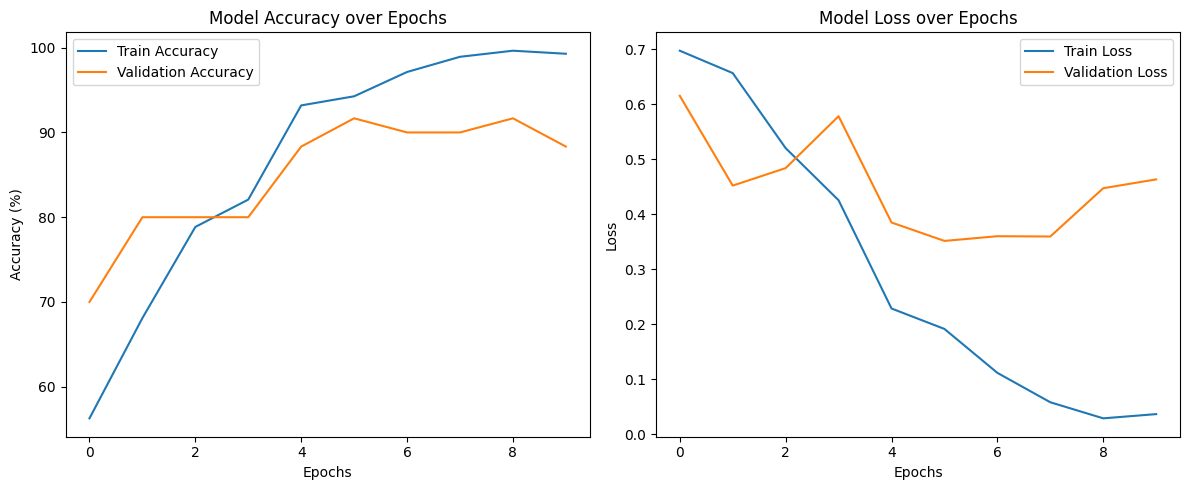


--- Final Validation Metrics (best ckpt) ---


{'loss': 0.447069813683629, 'Accuracy': 91.66666666666666, 'Precision': 100.0, 'Recall': 83.33333333333334, 'Specificity': 100.0, 'AUC': np.float64(96.88888888888889)}

--- Confusion Matrix (Val) ---


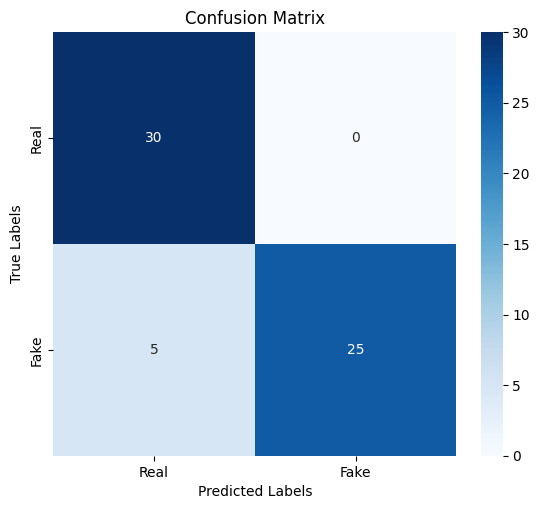


--- ROC Curve & AUC Score (Val) ---


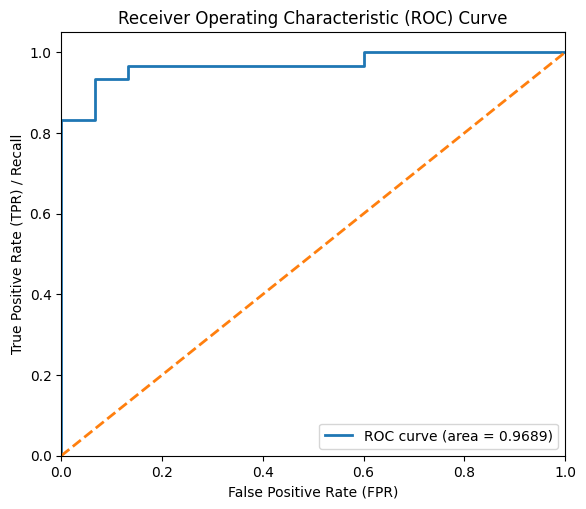


Classification Report (Val):
              precision    recall  f1-score   support

        REAL       0.86      1.00      0.92        30
        FAKE       1.00      0.83      0.91        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60


--- Final Test Metrics (best ckpt) ---


{'loss': 0.5356438077365359, 'Accuracy': 83.33333333333334, 'Precision': 83.33333333333334, 'Recall': 83.33333333333334, 'Specificity': 83.33333333333334, 'AUC': np.float64(92.77777777777777)}

--- Confusion Matrix (Test) ---


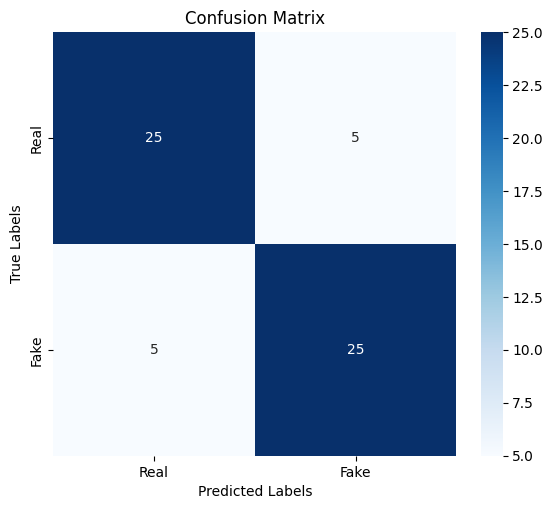


--- ROC Curve & AUC Score (Test) ---


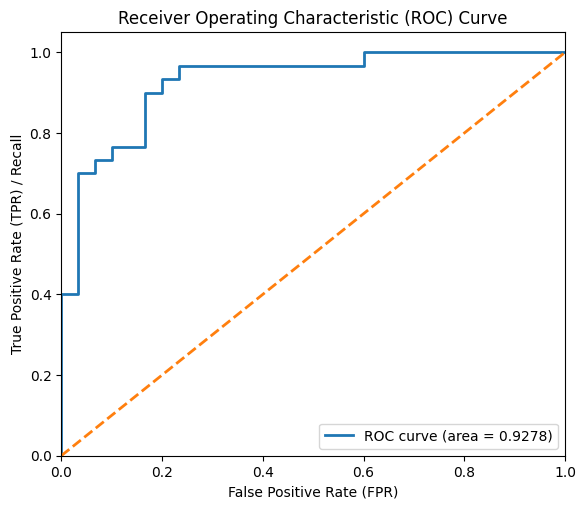


Classification Report (Test):
              precision    recall  f1-score   support

        REAL       0.83      0.83      0.83        30
        FAKE       0.83      0.83      0.83        30

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60


Best checkpoint saved at: /content/checkpoints/deepfake_run1_best.pt


In [7]:
model, history, val_metrics, test_metrics, ckpt_path = run_training(CFG, train_loader, val_loader, test_loader)
print("\nBest checkpoint saved at:", ckpt_path)

In [8]:
val_metrics

{'Accuracy': 91.66666666666666,
 'Precision': 100.0,
 'Recall': 83.33333333333334,
 'Specificity': 100.0,
 'AUC': np.float64(96.88888888888889),
 'y_pred': array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
 'p_fake': array([0.00287613, 0.97534865, 0.01180924, 0.9821002 , 0.98311055,
        0.9826843 , 0.00297762, 0.9831396 , 0.00362069, 0.0030467 ,
        0.9821786 , 0.9830679 , 0.98337066, 0.00293975, 0.00304703,
        0.00304638, 0.0030998 , 0.00288974, 0.9830314 , 0.00299723,
        0.97642267, 0.00314842, 0.0030834 , 0.00324074, 0.98211586,
        0.00492721, 0.00309086, 0.00431247, 0.9831607 , 0.98247313,
        0.02756801, 0.9830754 , 0.9770389 , 0.00525171, 0.00298062,
        0.09439191, 0.98269665, 0.00310099, 0.00310142, 0.98300767,
        0.9831066 , 0.00336309, 0.98274696, 0.00299041, 0.00288562,
        0.9824735

In [9]:
test_metrics

{'Accuracy': 83.33333333333334,
 'Precision': 83.33333333333334,
 'Recall': 83.33333333333334,
 'Specificity': 83.33333333333334,
 'AUC': np.float64(92.77777777777777),
 'y_pred': array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]),
 'p_fake': array([0.01255149, 0.03122577, 0.03999088, 0.98235023, 0.00355498,
        0.89923507, 0.0031034 , 0.9824683 , 0.9828864 , 0.9824652 ,
        0.00304305, 0.07175229, 0.9830778 , 0.00314045, 0.9810451 ,
        0.98314774, 0.00303818, 0.00308322, 0.811478  , 0.9822662 ,
        0.00305381, 0.06050897, 0.00313432, 0.00326267, 0.55783886,
        0.98223823, 0.00424321, 0.80003655, 0.70822823, 0.64939195,
        0.0030288 , 0.00567427, 0.00285605, 0.9829428 , 0.98303014,
        0.9834712 , 0.00324012, 0.00302357, 0.97859144, 0.9833172 ,
        0.00308831, 0.9832064 , 0.00325466, 0.00302132, 0.625